# RGB Images

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import rescale
import numpy as np
import scipy.io as sio
import os

# Path of images
path = 'C:/Users/DarkB/Downloads/ML Python Scripts/Project 1/ImsAndSegs'

# Load image data
img_load = sio.loadmat('C:/Users/DarkB/Downloads/ML Python Scripts/Project 1/ImsAndSegs/ImsAndTruths100075.mat')
img = img_load['Im']
seg_im = img_load['Seg1']

# Plot image
plt.imshow(rescale(seg_im,0.1,mode='reflect'))
plt.show()
img.shape

<Figure size 640x480 with 1 Axes>

(321, 481, 3)

## K-Means Algorithm Implementation

KMeans clustering time to do: 0.03s


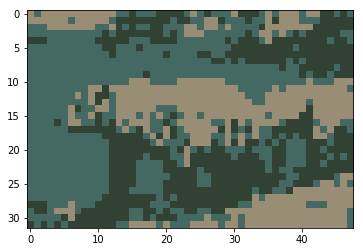

In [2]:
import time
import numpy as np
from sklearn.cluster import KMeans


#Downsample image
img_r = rescale(img,0.1,mode='reflect')
img_flat = img_r.reshape(img_r.shape[0] * img_r.shape[1], 3)
n_clusters = 3 

t0 = time.time()
# Initializing KMeans
kmeans = KMeans(n_clusters = n_clusters)

# Fitting with inputs
kmeans = kmeans.fit(img_flat)
clusters = kmeans.cluster_centers_[kmeans.predict(img_flat)]
t1 = time.time()

# Reshape flattened image
img_clustered = clusters.reshape(img_r.shape)

# Plot image
plt.imshow(img_clustered)
title = 'KMeans clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

 Step 1 - Binary Clusters Images (ONE CLUSTER)- Time to do: 0.37s


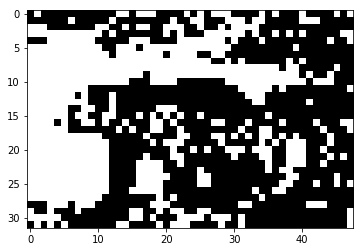

Step 2 - Label Connected Components - Time to do: 0.00s


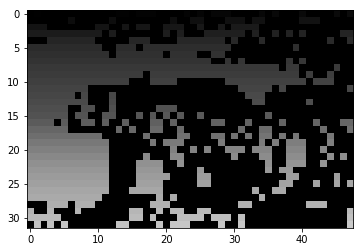

Step 3 - Remove Small Connected Components - Time to do: 0.00s


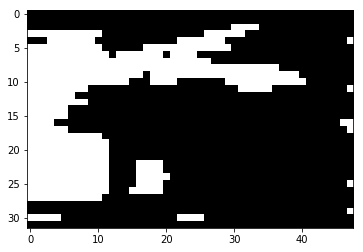

Step 4 - Smoothing Image - Time to do: 0.00s


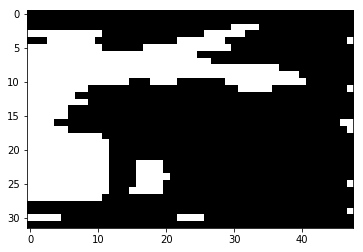

In [10]:
from skimage import measure
from skimage import morphology
from scipy.ndimage.filters import gaussian_filter

# Step 1 - Binary Clusters Images

# Separate the clusters into binary images --> This step need to be transformed into a function 
# that takes the number of clusters selected and separete into a binary image for each cluster
# Currently only works for ONE of the clusters

t0 = time.time()

first_cluster = np.copy(clusters)
for colors in range(first_cluster.shape[0]):
    if np.array_equal(first_cluster[colors],[np.unique(img_clustered)[3], np.unique(img_clustered)[5], np.unique(img_clustered)[4]]):
#         first_color[colors] = [np.unique(r_recolored)[3], np.unique(r_recolored)[5], np.unique(r_recolored)[4]]
          first_cluster[colors] = [1,1,1]
    else:
        first_cluster[colors] = [0,0,0]
        
cluster_1 = (first_cluster.reshape(img_r.shape))

t1 = time.time()

# Step 2 - Label Connected Components

# The connected components are labeled based on connected regions assiging the same integer value, based on 4 neighbors (default)
# This needs to be set within the funtion that evaluates each binary cluster image to label its connected components
# Reference: http://scikit-image.org/docs/dev/api/skimage.measure.html

t2 = time.time()

img_flat = first_cluster
all_labels = measure.label(img_flat)
img_labeled_by_components = all_labels.reshape(img_clustered.shape)

t3 = time.time()

# Step 3 - Remove Small Connected Components

# Remove connected components smaller than the specified size, in this case i picked 10 but this might change
# and reconver the image from labels into binary. Agains need to be placed into the generalized function
# Reference: http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects

t4 = time.time()

clean_cluster = morphology.remove_small_objects(img_labeled_by_components, 10)
clean_cluster[clean_cluster > 1] = 1
clean_cluster = clean_cluster.astype(float)

t5 = time.time()

# Step 4 - Smoothing Image

# The cleaned image is passed through a gaussing filter to smooth the output, it is not entirelly clear to me how it works
# so we might or mightn ot use this step

t6 = time.time()

img_flat_clean = clean_cluster.reshape(clean_cluster.shape[0] * clean_cluster.shape[1], 3)

s = 0.5 # sigma
w = 5 # window size
t = (((w - 1)/2)-0.5)/s #truncate


blurred = gaussian_filter(img_flat_clean, sigma=s, order=0, truncate=t)
blobs = blurred > 0.5 * blurred.mean()

img_cluster_filt = blobs.reshape(img_clustered.shape)

t7 = time.time()

# Step 5 - Vizualization

# This just plot the images

plt.figure(1)
plt.imshow(cluster_1)
title = ' Step 1 - Binary Clusters Images (ONE CLUSTER)- Time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()
plt.figure(2)
plt.imshow(img_labeled_by_components)
title = 'Step 2 - Label Connected Components - Time to do: %.2fs' % (t3 - t2)
print(title)
plt.show()
plt.figure(3)
plt.imshow(clean_cluster)
title = 'Step 3 - Remove Small Connected Components - Time to do: %.2fs' % (t5 - t4)
print(title)
plt.show()
plt.figure(4)
plt.imshow(img_cluster_filt.astype(float))
title = 'Step 4 - Smoothing Image - Time to do: %.2fs' % (t7 - t6)
print(title)
plt.show()

# Hyperspectral Images

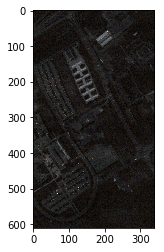

(610, 340, 3)

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio
import os


# hsimg_load = sio.loadmat('SanBarHyperIm.mat')
# hsimg_data = hsimg_load['SanBarIm88x400']
hsimg_load = sio.loadmat('PaviaHyperIm.mat')
hsimg_data = hsimg_load['PaviaHyperIm']
himage_display = hsimg_data[:,:,0:3]
plt.imshow(himage_display)
plt.show()
hsimg_data[:,:,0:3].shape

We need about 3 components to retain 95% of the variance


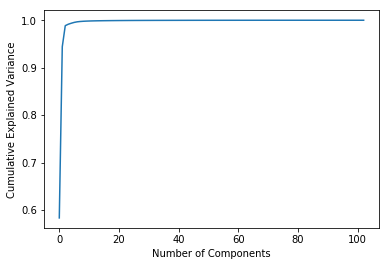

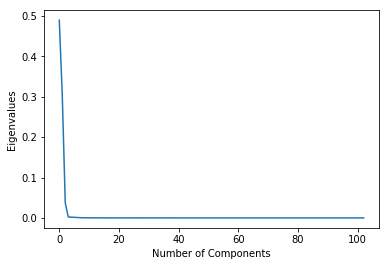

In [17]:
from sklearn.decomposition import PCA
data = hsimg_data.reshape(hsimg_data.shape[0] * hsimg_data.shape[1], hsimg_data.shape[2])
pca = PCA().fit(data)
cum_var = np.cumsum(pca.explained_variance_ratio_)
eigenvalues = pca.explained_variance_

count = 0
for var in cum_var:
    count += 1
    if var >= 0.95:
        n_components = count
        answer = "We need about "+ str(n_components) + " components to retain 95% of the variance"
        print(answer)
        break
        
plt.figure(1)
plt.plot(cum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.figure(2)
plt.plot(eigenvalues)
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.show()

# Minumum Noise Factor --> Similar to PCA but removes noise from bands

In [43]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.transform import rescale
from sklearn.cluster import KMeans
import numpy as np
import time

#Reshape to 2D - one column per component
data = hsimg_data.reshape(hsimg_data.shape[0] * hsimg_data.shape[1], hsimg_data.shape[2])

#Using PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data)

#Since my data is not between [0,1], I rescale the data
min_max_scaler = MinMaxScaler()
reduced_data_scaled = min_max_scaler.fit_transform(reduced_data)

#Turn data back into 3 dimensions to control the downsampling of the data
reduced_data_3D = reduced_data_scaled .reshape(hsimg_data[:,:,0:3].shape)
# img_r = rescale(reduced_data_3D,0.1,mode='reflect')

#Flatten my data again for algorithm input
# img_data = img_r.reshape(img_r.shape[0] * img_r.shape[1], 3)
img_data = reduced_data_3D.reshape(reduced_data_3D.shape[0] * reduced_data_3D.shape[1], 3)

KMeans clustering time to do: 14.03s


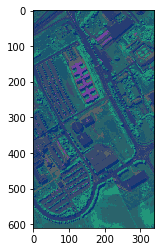

In [35]:
from sklearn.cluster import KMeans

n_clusters = 9

# Initializing KMeans
kmeans = KMeans(n_clusters=n_clusters)
# Fitting with inputs
t0 = time.time()

# Run algorithm
kmeans = kmeans.fit(img_data)
clusters = kmeans.cluster_centers_[kmeans.predict(img_data)]
t1 = time.time()

# Reshape the data into 3D
# img_clustered = clusters.reshape(img_r.shape)
img_clustered = clusters.reshape(reduced_data_3D.shape)

# Plot the data
plt.imshow(img_clustered)
title = 'KMeans clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

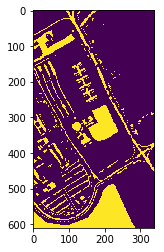

In [37]:
htruth_load = sio.loadmat('PaviaGrTruthMask.mat')
htruth_mask = htruth_load['PaviaGrTruthMask']
plt.imshow(htruth_mask)
plt.show()

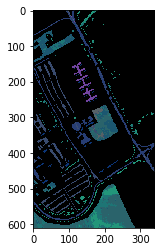

In [61]:
# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()

# apply the mask to your image
masked_image = img_clustered*mask

plt.imshow(masked_image)
plt.show()

# Things that need to get done:

#### Find a way to select the number of cluster. A posteriori will not work must be a priori. Some methods he mentioned:
        # Xie-Beni Index: https://programtalk.com/vs2/python/9922/pygmi/pygmi/clust/xie_beni.py/
        # Use objective function
        # Use scatter matrix
        
#### MyClustEvalRGB: Create RGB function to does the same as above for each cluster and combienes it back together 

#### MyClustEvalHyper: Create Hyperspectral function that does similar (skips step 3,4,5) but does this: 
        # For Hyperspectral multiply segmentation by the ground truth mask. 
        # Dont use connected compontens, use cluster labels. Set number of cluster to 9
        # This is doneish, but I would like to run it throught color separator to recolor it into nicer colors
        
#### Run the experiments for each algorithm

#### Finish the report and consolidate it
